# TP1 Deep QLearning

Dans ce TP, l'objectif est d'implémenter un agent apprenant à faire atterir un vaisseau sur la lune avec l'algorithme Deep Q-Network. Pour cela vous allez utiliser [PyTorch](https://pytorch.org/) et [Gymnasium](https://gymnasium.farama.org/). 

<img src='img/lunarlander.png'  width=500px>

# 1. Consignes

> <span style="color:red">Compléter ce notebook et les différents fichiers python associés</span>.  
> 
>  <span style="color:red">Répondre aux questions</span> (dans les cellules <span style="color:blue">Votre réponse: </span> )


> Le code doit être fonctionnel avec l'environnement virtuel du TP. Si d'autres packages que ceux présents dans l'environnement virtuel créé au départ sont nécessaires, vous devez ajouter à votre dépôt un fichier `environnement.yaml` qui est un export de votre environnement virtuel. Ce fichier est obtenu avec la commande suivante:  ```conda env export > environnement.yaml```



# 2. Import des packages

In [126]:
%reset -f
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

def init_seed(seedval):
    torch.manual_seed(seedval)
    np.random.seed(seedval)
    random.seed(seedval)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 3. Gymnasium

En apprentissage par renforcement, il y a deux concepts fondamentaux : l’agent et l’environnement.
- L’agent est l’entité apprenante qui observe l’environnement et agit sur celui-ci selon les actions disponibles. Son objectif est de maximiser la récompense cumulée qu’il recoit de l’environnement avec lequel il interagit.
- L'agent interagit avec l'environnement à travers la boucle de perception/action ce qui nécessite de définir :
    - Un espace d’action.
    - Un espace d’état (ou observation).
    - Une fonction de récompense.
  
[Gymnasium](https://gymnasium.farama.org/) propose une interface open source unifiée entre un agent et un environnement.
- [Gymnasium](https://gymnasium.farama.org/) propose un ensemble d'environnements pour des tâches d'apprentissage par renforcement. La plupart des environnements ont leur code source disponible sur [GitHub](https://github.com/Farama-Foundation/Gymnasium/tree/main/gymnasium/envs). De nouveaux environnements peuvent aussi être créés à condition qu'ils soient compatibles avec l'interface. 
- Grâce à l'interface unifiée, il est possible de définir indépendamment un agent de l’environnement avec lequel il interagit (et inversement). 
- Lorsque certains pré-traitements sont nécessaires sur les actions, observations, récompenses, ... il est possible d’encapsuler l’environnement dans un **wrapper**, celui-ci se chargera du pré-traitement. 




>  <span style="color:green">Documentation de Gymnasium</span>: [utilisation basique](https://gymnasium.farama.org/content/basic_usage/), [API pour les environnements](https://gymnasium.farama.org/api/env/), ...




##  3.1 - Caractéristiques de l'environnement LunarLander

Dans ce TP, nous allons implémenter un agent qui interagira avec l'environnement **LunarLander**, présenté  [ici](https://gymnasium.farama.org/environments/box2d/lunar_lander/) et le code source est [ici](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py). 2 versions de LunarLander existent: avec des actions discrètes ou des actions continues.

> <span style="color:green">Quelle version choisir pour utiliser le DQN ? Pourquoi ? 



> <span style="color:blue">Votre réponse: </span>
Dans notre cas, on utilisera la version avec des actions discrètes puisqu'on aura besoin pour estimer la valeur Q pour chaque action possible à partir d'un état donné. Pour utiliser le DQN, il faut alors choisir un environements à espaces d'actions discret ou finis.

Il existe plusieurs fonctions clés pour interagir avec un environnement Gymnasium ( [utilisation basique](https://gymnasium.farama.org/introduction/basic_usage/) et [API](https://gymnasium.farama.org/api/env/)).


> <span style="color:green">Compléter la cellule de code ci-dessous pour afficher:
> 
> - **les dimensions pour les espaces d'états et d'actions** de l'environnement `LunarLander`.
> - les bornes min et max pour les dimensions de l'état
> - un échantillon pris au hasard dans chaque espace. 

In [127]:
env = gym.make("LunarLander-v3")

#TODO
print("Dimensions pour les espaces d'actions: " + str(env.action_space))
print("Dimensions pour les espaces d'états: " + str(env.observation_space.shape))
print("Les bornes max des états: " + str(env.observation_space.high))
print("Les bornes min des états: " + str(env.observation_space.low))
print("Un échantillon aléatoire de l'espace d'états: " + str(env.observation_space.sample()))


Dimensions pour les espaces d'actions: Discrete(4)
Dimensions pour les espaces d'états: (8,)
Les bornes max des états: [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ]
Les bornes min des états: [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ]
Un échantillon aléatoire de l'espace d'états: [ 1.3517162   0.69529796 -6.199272   -0.16349587  5.617558   -4.0210586
  0.3824424   0.34116778]


> <span style="color:green"> </span>  A quoi correspond dans le cas du LunarLander une terminaison d'un épisode avec *terminated* à True ? avec *truncated* à True ?

> <span style="color:blue">Votre réponse: </span>
On termine un épisode avec *terminated* à True si:
- Le vaisseau s'écrase (le corps du vaisseau touche la surface de la lune)
- Le vaisseau sort du cadre de l'interface (les coordonnée de x dépasse 1)
- Le vaisseau n'est plus réveiller. D'après les docs de Box2D, un coprs qui n'est réveillé est un corps qui ne bouge plus et qui ne touche aucune surface.

On termine un épisode avec *trancated* à True si un épisode est terminé à cause des contraintes externes comme la limite du temps, la limite des pas d'apprentissage, etc...

## 3.2 Interaction et affichage de l'environnement sur un épisode

> <span style="color:green">Exécuter une instance de l'environnement `LunarLander` pendant un épisode avec des **actions aléatoires**. Afficher l'environnement à chaque pas pour visualiser le comportement du vaisseau. A la fin de l'épisode, afficher la somme des récompenses obtenues sur l'épisode et la raison pour laquelle l'épisode s'est terminé. </span>



In [128]:
env = gym.make("LunarLander-v3", render_mode="human")
#TODO

# Reset environment to start a new episode
observation, info = env.reset()

print(f"Starting observation: {observation}")

episode_over = False
total_reward = 0

while not episode_over:
    action = env.action_space.sample()  # Random action for now - real agents will be smarter!

    # Take the action and see what happens
    observation, reward, terminated, truncated, info = env.step(action)

    total_reward += reward
    episode_over = terminated or truncated
    env.render()
print(f"New observation: {observation}")
print(f"Episode finished! Total reward: {total_reward}")
print(f"Episode finished with terminated = {terminated} and truncated = {truncated}")
env.close()


Starting observation: [ 0.0025527   1.4141281   0.25853178  0.14257199 -0.00295101 -0.05856137
  0.          0.        ]
New observation: [ 0.2790242   0.05361415 -0.06317629 -0.01434038 -0.58324176  0.18497697
  1.          0.        ]
Episode finished! Total reward: -152.35015120357113
Episode finished with terminated = True and truncated = False


L'épisode fini puisque le vaisseau s'écrase sur la lune. On se retrouve alors avec *terminated* à True et *truncated* à False.

# 4. Agent simple (sans apprentissage)

Vous devez maintenant implémenter un **agent simple** qui utilise une **Q fonction paramétrée** (réseau de neurones) pour choisir ses actions selon une stratégie $\epsilon$-greedy (mais pas d'apprentissage pour l'instant).

> <span style="color:green">- Quels éléments seront en entrée du NN ? En sortie ? Quelle sera la dimension de l'entrée ? De la sortie ? </span>


> <span style="color:blue">Votre réponse: </span>

On aura en entrée les 8 dimensions du vecteurs de l'états: les coordonnées x et y du vaisseau, les coordonées x et y de la vélocité du vaisseau, l'angle du vaisseau, la vélocité de l'angle du vaisseau et en fin les deux booléens pour représenter le contact du pied gauche et pied droite du vaisseau avec la lune.

On sortie on retrouvera le nombres d 'actions discrets possibles qui de dimensions 4: 0 : ne rien faire, déclencher le moteur d'orientation gauche, déclencher le moteur principal et enfin déclencher le moteur d'orientation droite

> <span style="color:green">- Quelle fonction d'activation sera utilisée sur le dernière couche du réseau ? Pourquoi ? </span>


> <span style="color:blue">Votre réponse: </span>
On utilise aucune fonction d'activation car sur la dernière couche de réseau on n'utilise pas de fonction d'activation sauf dans le cas d'une classification 

- définir l'architecture du réseau de neurones en complétant `QNN.py`. Ce réseau va approximer la Q-fonction comme dans DQN (pour l'instant, les poids du réseau ne seront pas mis à jour, le réseau est uniquement utilisé en prédiction).

- définir un agent simple en complétant `agentsimple.py`: il utilisera la prédiction du réseau de neurones pour choisir ses actions selon une stratégie d’exploration $\epsilon$-greedy.

- utiliser cet agent sur plusieurs épisodes dans `LunarLander`. Vous utiliserez une décroissance de l'exploration, i.e. que $\epsilon$ va décroitre à chaque épisode, en démarrant à une valeur élevée (beaucoup d'exploration) et avec une borne minimum. Ainsi, au premier épisode, $\epsilon=\epsilon_{start}$, et à chaque épisode, $\epsilon=max(\epsilon_{end}, \epsilon_{decay}*\epsilon)$. Par exemple sur 1000 épisodes, les valeurs peuvent être $\epsilon_{start} = 1.0$, $\epsilon_{end} = 0.01$ et $\epsilon_{decay} = 0.995$.

- proposer un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser le fichier `utils.py`, le wrapper [RecordEpisodeStatistics](https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordEpisodeStatistics ),  ...).


In [129]:
#Reload all modules every time before executing the Python code typed
%autoreload 2
# import depuis un fichier python local 
from QNN import QNN 
from agentsimple import AgentSimple
import utils
from gymnasium.wrappers import RecordEpisodeStatistics

Episode 100, Total Reward: -102.73530957872761, Epsilon: 0.606
Episode 200, Total Reward: -122.46096733238582, Epsilon: 0.367
Episode 300, Total Reward: -474.8146221926453, Epsilon: 0.222
Episode 400, Total Reward: -393.8760979536218, Epsilon: 0.135
Episode 500, Total Reward: -434.84791205313763, Epsilon: 0.082
Episode 600, Total Reward: -138.44997830380498, Epsilon: 0.049
Episode 700, Total Reward: -478.530364314286, Epsilon: 0.030
Episode 800, Total Reward: -97.90092420250716, Epsilon: 0.018
Episode 900, Total Reward: -484.709101347188, Epsilon: 0.011
Episode 1000, Total Reward: -149.94011588749584, Epsilon: 0.010


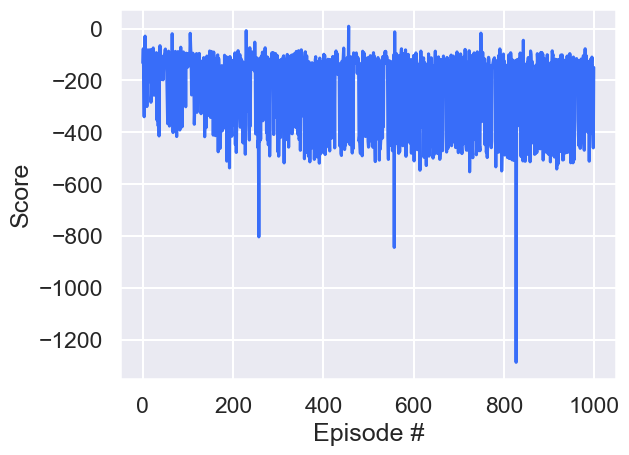

In [130]:
#TODO

init_seed(42)

eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995


env = gym.make("LunarLander-v3")
env = RecordEpisodeStatistics(env)

agent = AgentSimple(dim_etat=env.observation_space.shape[0], 
                   dim_action=env.action_space.n)

n_episodes = 1000
scores = []
epsilons = []
episodes_list = []

epsilon = eps_start
for episode in range(n_episodes):
    epsilon = max(eps_end, eps_decay*epsilon)
    epsilons.append(epsilon)

    state, info = env.reset()
    done = False
    total_reward = 0
    truncated = False
    while not done and not truncated:
        action = agent.action_egreedy(state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)

        state = next_state
        total_reward += reward
        done = terminated

    scores.append(total_reward)
    episodes_list.append(episode)
    if (episode+1) % 100 == 0:
        print(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

env.close()

utils.plot_sumrwdperepi(scores)

# 5. Deep QLearning avec Replay Buffer

L'algorithme (sans réseau cible) est donné ci-dessous:

<img src='img/DQN2.png'  width=700px>


- La phase d'**échantillonage** est une phase d'interaction avec l'environnement (sans apprentissage), pendant laquelle l'agent stocke en mémoire toutes les transitions rencontrées. Une transition est un tuple `(état,action,état_suivant,récompense,fin_episode)`. La mémoire a une taille maximale; lorsqu’elle est dépassée, les nouvelles transitions remplacent les plus anciennes. 

- La phase d'**apprentissage** permet de mettre à jour les paramètres de la fonction *Q* à partir de plusieurs (minibatch) transitions (64 par exemple) stockées dans la mémoire. La phase d'apprentissage est réalisée tous les `t` pas (ou actions) dans l'environnement (par ex. $t=4$).

- La classe `ReplayBuffer` du fichier `replaybuffer.py` permet de stocker des transitions dans une mémoire et de récupérer des minibatch de transitions.


Vous devez implémenter l'algorithme du **Deep QLearning avec ReplayBuffer** donné ci-dessus.

Remarque: 
- vous n'utiliserez pas de réseau cible (*target network*) pour l'instant.
- Pour l'optimizer, SGD et [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) sont particulièrement adaptés. 
- Dans la phase d'apprentissage, les éléments récupérés dans un minibatch  sont des tenseurs de taille $d \times dim\_element$. Vous devez dans cette phase faire des calculs tensoriel directement (et pas de boucle for sur $d$ !)
- Voici aussi des liens vers différentes fonctions de PyTorch qui pourraient vous être utiles: [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html), [gather](https://pytorch.org/docs/stable/generated/torch.gather.html)


> <span style="color:green">Compléter la classe `AgentDQN`</span> 
>
> <span style="color:green">Implémenter l'algorithme dans la fonction *dqnalgo* ci-dessous.  </span> 
>
> <span style="color:green">Utiliser cet agent sur plusieurs épisodes dans l'environnement `LunarLander`. Vous proposerez un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser `utils.py`).</span> 


 
 

In [131]:
#Reload all modules every time before executing the Python code typed
%autoreload 2
from replaybuffer import ReplayBuffer
from agentdqn import AgentDQN
import torch.nn as nn
import numpy as np

In [135]:
#TODO
T = 1000
LEARNSTEP = 4
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
def dqnalgo(agent,env,nb_episodes,eps_start,eps_end,eps_decay):
    """
        Retourne la somme des recompenses par épisode
    """
    scores = []
    epsilons = []
    episodes_list = []


    T = env.spec.max_episode_steps
    epsilon = eps_start
    for episode in range(nb_episodes):
        epsilon = max(eps_end, eps_decay*epsilon)
        epsilons.append(epsilon)

        state, info = env.reset()
        done = False
        total_reward = 0
        truncated = False
        for t in range(1,T):
            action = agent.action_egreedy(state, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)

            agent.phase_echantillonage(state, action, reward, next_state, terminated)
            if t%LEARNSTEP == 0 and t>64:
                agent.phase_apprentissage()
            state = next_state
            total_reward += reward
            done = terminated
            if terminated or truncated:
                break
            
        scores.append(total_reward)
        episodes_list.append(episode)
        if (episode+1) % 100 == 0:
            print(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")
    env.close()
    return scores, epsilons, episodes_list


In [40]:
env = gym.make("LunarLander-v3")

#TOCOMPLETE
init_seed(42)
agent = AgentDQN(dim_etat=env.observation_space.shape[0], 
                   dim_action=env.action_space.n, gamma=0.99)
scores, epsilons, episodes_list = dqnalgo(agent,env,1000,eps_start,eps_end,eps_decay)


Episode 100, Total Reward: -130.92304657404435, Epsilon: 0.606
Episode 200, Total Reward: 112.73585926024653, Epsilon: 0.367
Episode 300, Total Reward: 97.30528852272819, Epsilon: 0.222
Episode 400, Total Reward: -239.14258890632772, Epsilon: 0.135
Episode 500, Total Reward: 287.99001077660705, Epsilon: 0.082
Episode 600, Total Reward: -37.361806326991314, Epsilon: 0.049
Episode 700, Total Reward: 212.51405361096312, Epsilon: 0.030
Episode 800, Total Reward: 283.6610915208457, Epsilon: 0.018
Episode 900, Total Reward: 260.11845043299576, Epsilon: 0.011
Episode 1000, Total Reward: 267.7460383991613, Epsilon: 0.010


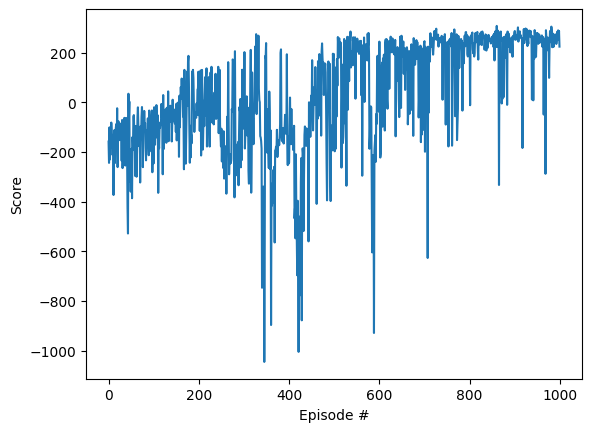

In [41]:
utils.plot_sumrwdperepi(scores)

> <span style="color:green">Faites maintenant une moyenne sur différents seed, avec un apprentissage par seed, et tracer le résultat (somme des récompenses par épisodes) moyenné sur ces seed. Vous utiliserez `init_seed()` et pouvez utiliser `utils.py`.</span> </span> 

In [43]:
seeds = [42, 43, 44,45,46]
all_scores = []
for seed in seeds:
    init_seed(seed)
    env = gym.make("LunarLander-v3")
    agent = AgentDQN(dim_etat=env.observation_space.shape[0], 
                   dim_action=env.action_space.n, gamma=0.99)
    scores, epsilons, episodes_list = dqnalgo(agent,env,1000,eps_start,eps_end,eps_decay)
    all_scores.append(scores)

Episode 100, Total Reward: -244.5592047439198, Epsilon: 0.606
Episode 200, Total Reward: -118.75271758420737, Epsilon: 0.367
Episode 300, Total Reward: -110.02872415218178, Epsilon: 0.222
Episode 400, Total Reward: -217.33199860297654, Epsilon: 0.135
Episode 500, Total Reward: 265.6686481651261, Epsilon: 0.082
Episode 600, Total Reward: 255.9832976588325, Epsilon: 0.049
Episode 700, Total Reward: 254.97110095846392, Epsilon: 0.030
Episode 800, Total Reward: 256.758546989621, Epsilon: 0.018
Episode 900, Total Reward: 163.94741914471408, Epsilon: 0.011
Episode 1000, Total Reward: 243.8014062165553, Epsilon: 0.010
Episode 100, Total Reward: -144.85024250559377, Epsilon: 0.606
Episode 200, Total Reward: 43.06897216257127, Epsilon: 0.367
Episode 300, Total Reward: -165.60458260552963, Epsilon: 0.222
Episode 400, Total Reward: -332.1128595388948, Epsilon: 0.135
Episode 500, Total Reward: -148.90132897838706, Epsilon: 0.082
Episode 600, Total Reward: -228.90510167248453, Epsilon: 0.049
Episod

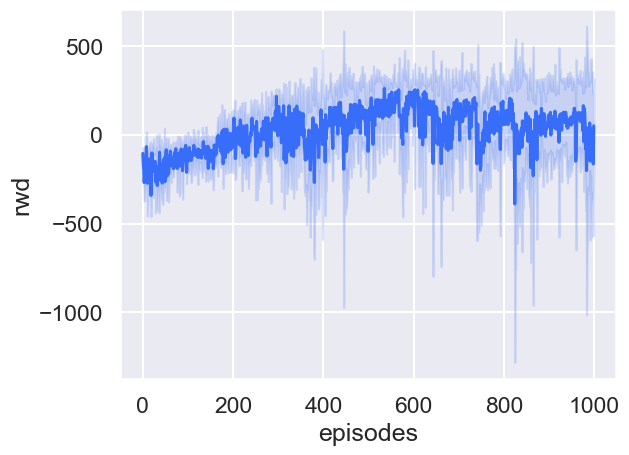

In [44]:
for i in range(len(all_scores)):
    all_scores[i] = [[r] for r in all_scores[i]]
utils.plot_sumrwdperepi_overseed(all_scores)

# 6. Deep QLearning avec réseau cible

Il se peut que votre agent précédent apprenne des comportements intéressants mais qu’ils soient très instables. On va maintenant ajouter un réseau cible pour l'améliorer.

> <span style="color:green"> Quelle est la cause des instabilités de l'algorithme précédent ? Pourquoi le réseau cible améliore ces instabilités ?</span> 

> <span style="color:blue">Votre réponse: </span>
L’instabilité vient du fait que le même réseau sert à la fois pour prédire les valeurs 
𝑄
Q et pour calculer les cibles lors de l’apprentissage. Comme les poids changent constamment, les cibles changent aussi, ce qui rend l’apprentissage instable.

Le réseau cible corrige ce problème en introduisant un second réseau, mis à jour moins fréquemment. Le réseau principal choisit les actions, tandis que le réseau cible fournit des cibles plus stables, ce qui rend l’apprentissage plus régulier et facilite la convergence.

L'algorithme DQN (avec réseau cible) est donné ci-dessous:

<img src='img/DQNcible.png'  width=500px>


Le réseau cible sera mis à jour toutes les N étapes d'apprentissage (500 par exemple si $t=4$) en recopiant entièrement le réseau de neurone original dans le duplicat.

Pour copier des poids d'un réseau de neurone vers un autre, la méthode `copy_` peut être appelée sur les paramètres:

`for param_duplicat, param_source in zip(model_duplicat.parameters(), model_source.parameters()):`
           
`param_duplicat.data.copy_(param_source.data)`

> <span style="color:green"> Compléter la classe `AgentDQNCible` pour implémenter un agent apprenant avec DQN (deep QLearning et *target network*).</span> 






> <span style="color:green">Utiliser cet agent **dans l'algorithme dqnalgo précédent**. Vous proposerez un tracé de la somme des récompenses obtenues par épisode sur plusieurs seed.</span> 

In [134]:
from agentdqncible import AgentDQNCible

In [138]:
# TODO
env = gym.make("LunarLander-v3")

#TOCOMPLETE
init_seed(42)
agent = AgentDQNCible(dim_etat=env.observation_space.shape[0], 
                   dim_action=env.action_space.n, gamma=0.99)
scores, epsilons, episodes_list = dqnalgo(agent,env,1000,eps_start,eps_end,eps_decay)


Episode 100, Total Reward: -76.16107626076852, Epsilon: 0.606
Episode 200, Total Reward: -1.2930702688719755, Epsilon: 0.367
Episode 300, Total Reward: 164.74438163089297, Epsilon: 0.222
Episode 400, Total Reward: 223.74964765874603, Epsilon: 0.135
Episode 500, Total Reward: 233.53058905738826, Epsilon: 0.082
Episode 600, Total Reward: 278.1650954958268, Epsilon: 0.049
Episode 700, Total Reward: 197.2098197831118, Epsilon: 0.030
Episode 800, Total Reward: 209.42348030394191, Epsilon: 0.018
Episode 900, Total Reward: 228.81311517708275, Epsilon: 0.011
Episode 1000, Total Reward: 263.6954091367445, Epsilon: 0.010


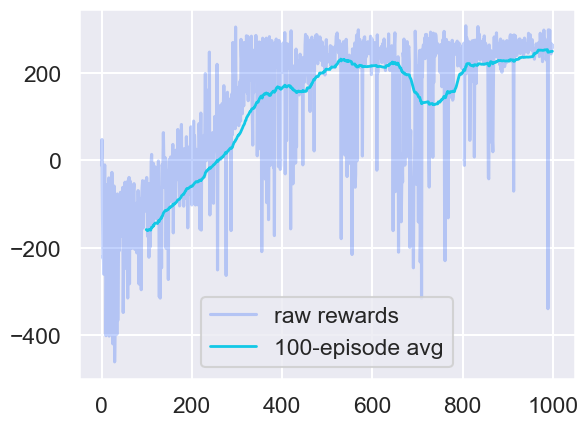

In [139]:
import numpy as np
window = 100
moving_avg = np.convolve(scores, np.ones(window)/window, mode='valid')

plt.plot(scores, label="raw rewards", alpha=0.3)
plt.plot(range(window-1, len(scores)), moving_avg, label=f"{window}-episode avg", linewidth=2)
plt.legend()
plt.show()

# 6. Sauvegarde d'un agent

> <span style="color:green"> Sauvegarder un agent qui a correctement appris dans un fichier 'monAgentDQN.pth'. Vous préciserez ci-dessous les hyperparamètres utilisés pour cet agent. </span> 



> <span style="color:blue">Hyperparamètres de l'agent: </span>

In [11]:
#Exemple de code pour sauvegarde d'un réseau
savedfile = 'checkpoint2kEpisodes.pth'
torch.save(agent.qnn.state_dict(), savedfile)

# Exemple de code pour chargement d'un reseau sauvegarde
state_dict = torch.load(savedfile)
agent.qnn.load_state_dict(state_dict)

C:\Users\etulyon1\AppData\Local\Temp\ipykernel_11604\785261355.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(savedfile)


<All keys matched successfully>

> <span style="color:green"> Proposer un code ci-dessous pour visualiser un épisode de cet agent en mode glouton. </span> 


In [140]:
env = gym.make("LunarLander-v3", render_mode="human")
#TODO 
state, info = env.reset()
done = False
total_reward = 0
truncated = False
while not done and not truncated:
    action = agent.action_egreedy(state, 0)
    next_state, reward, terminated, truncated, info = env.step(action)

    state = next_state
    total_reward += reward
    done = terminated
    env.render()
print(f"New observation: {state}")
print(f"Episode finished! Total reward: {total_reward}")
print(f"Episode finished with terminated = {terminated} and truncated = {truncated}")
env.close()

New observation: [-7.744036e-02 -7.419610e-04  0.000000e+00  0.000000e+00 -4.716897e-04
  0.000000e+00  1.000000e+00  1.000000e+00]
Episode finished! Total reward: 269.1356596380763
Episode finished with terminated = True and truncated = False


> <span style="color:green"> Si vous avez testé différents hyperparamètres, vous pouvez le préciser ci-dessous. </span> 

> <span style="color:blue">Hyperparamètres testés: </span>
on va essayer de lancer des tests avec un nombre d'épisodes plus petit et un LearnStep plus grand avec un gamma = 0.7 et une décroissance plus rapide de epsilon ($\epsilon_{decay} = 0.9$)

In [61]:
# Close previous environment if it exists to avoid display Surface quit error
try:
    env.close()
except Exception:
    pass

init_seed(42)
LEARNSTEP = 8
eps_decay = 0.995
env = gym.make("LunarLander-v3")
agent = AgentDQNCible(dim_etat=env.observation_space.shape[0], 
                   dim_action=env.action_space.n, gamma=0.99)
scores, epsilons, episodes_list = dqnalgo(agent,env,500,eps_start,eps_end,eps_decay)

Episode 100, Total Reward: -184.00600345559315, Epsilon: 0.606
Episode 200, Total Reward: -19.66165796247688, Epsilon: 0.367
Episode 300, Total Reward: 74.27204401921477, Epsilon: 0.222
Episode 400, Total Reward: 242.1211515395804, Epsilon: 0.135
Episode 500, Total Reward: 249.82809436888016, Epsilon: 0.082


Un gamma trop faible (par exemple 0.9 ou 0.95) conduit l'agent à devenir moin gourmand, en privilégiant les récompenses immédiates et en négligeant l'exploration, ce qui se traduit par des politiques moin optimales dans des environnements. 
Après une analyse comparative des performances, la valeur de 0.99 s'est avérée optimale car elle permet de maintenir un équilibre approprié entre l'exploration des récompenses immédiates et la considération des conséquences futures. Par conséquent, il est recommandé de fixer définitivement ce paramètre à 0.99 pour cet environnement spécifique.

In [125]:
try:
    env.close()
except Exception:
    pass

init_seed(42)
LEARNSTEP = 4 # LearnStep plus grand
eps_decay = 0.98
env = gym.make("LunarLander-v3") 
agent = AgentDQNCible(dim_etat=env.observation_space.shape[0], 
                   dim_action=env.action_space.n, gamma=0.99)
scores, epsilons, episodes_list = dqnalgo(agent,env,500,eps_start,eps_end,eps_decay)

Episode 100, Total Reward: -184.55921932070976, Epsilon: 0.133
Episode 200, Total Reward: -148.61761800348904, Epsilon: 0.018
Episode 300, Total Reward: -132.0986708001625, Epsilon: 0.010
Episode 400, Total Reward: -143.11130336297168, Epsilon: 0.010
Episode 500, Total Reward: -165.23375150774166, Epsilon: 0.010


Après plusieurs analyse avec différentes valeurs, on a remarqué qu' un $\epsilon_{\text{decay}}$ faible accélère la convergence vers $\epsilon = 0.1$, mais réduit trop rapidement l'exploration, risquant de converger vers des solutions sous-optimales.

Concernant LearnStep, des valeurs supérieures à 4 dégradent l'apprentissage. Un intervalle trop long entre les mises à jour sous-utilise le replay buffer et destabilise l'optimisation. La valeur optimale se situe autour de 4 pour équilibrer stabilité et efficacité.

In [120]:
env = gym.make("LunarLander-v3", render_mode="human")
#TODO 
state, info = env.reset()
done = False
total_reward = 0
truncated = False
while not done and not truncated:
    action = agent.action_egreedy(state, 0.0)
    next_state, reward, terminated, truncated, info = env.step(action)

    state = next_state
    total_reward += reward
    done = terminated
    env.render()
print(f"New observation: {state}")
print(f"Episode finished! Total reward: {total_reward}")
print(f"Episode finished with terminated = {terminated} and truncated = {truncated}")
env.close()

New observation: [-4.3188382e-02 -9.1659068e-04  0.0000000e+00  0.0000000e+00
  2.5136438e-03  0.0000000e+00  1.0000000e+00  1.0000000e+00]
Episode finished! Total reward: 287.33832123907473
Episode finished with terminated = True and truncated = False
